# <center>Day 2: matching models with transferable utility</center>
### <center>Alfred Galichon (NYU+ScPo)</center>
## <center>'math+econ+code' masterclass on equilibrium transport and matching models in economics</center>
<center>© 2020-2021 by Alfred Galichon.  Support from  NSF DMS-1716489 and ERC CoG-866274 EQUIPRICE grants is acknowledged.</center>

#### <center>with Python code</center>

**If you reuse material from this masterclass, please cite as:**<br>
Alfred Galichon, 'math+econ+code' masterclass on equilibrium transport and matching models in economics, June 2021. https://github.com/math-econ-code/mec_equil

# References

## Textbooks
* [OTME] Alfred Galichon (2016). *Optimal transport methods in economics*. Princeton.
* Pierre-André Chiappori (2017). *Matching with Transfers: The Economics of Love and Marriage*. Princeton.

## Papers

* Llyod Shapley and Martin Shubik (1971). "The assignment game I: The core." *International Journal of Game Theory*  1, pp. 111–130.
* Becker (1973). "A theory of marriage part 1." *Journal of Political Economy*.
* Eugene Choo and Aloysius Siow (2006). "Who marries whom and why." *Journal of Political Economy* 114, no. 1, pp. 175-201.
* Alfred Galichon and Bernard Salanié (2011-2021). "Cupid's invisible hands: Social Surplus and Identification in Matching Models". *Review of Economic Studies*, forthcoming.
* Arnaud Dupuy, Alfred Galichon, Sonia Jaffe, and Scott Kominers (2020). "Taxation in matching markets". *International Economic Review*, forthcoming. 

## Loading the libraries

First, let's load the libraries:

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from time import time

# !pip install gurobipy
import gurobipy as grb
import scipy.sparse as spr


# Generating worker and firm data

We will consider an academic job market, where candidate professors match with colleges--or rather, academic positions, as each position can only be filled by one applicant. 

A professor $x$ has characteristics $\xi(x) \in \mathbb{R}^d$ where $\xi$ includes measures of skills, such as general skills<br>
* $\xi_0$=teaching ability,<br>
* $\xi_1$=research ability, and<br>
* $\xi_2$=collegiality<br>
as well as specific skills, like<br>
* $\xi_3,\xi_4,\xi_5$=specialization in micro, macro, and econometrics<br>
and in addition, let's assume $\xi$ also encodes geographic coordinates of the applicant's residential address<br>
* $\xi_6,\xi_7$=residential address, (horizontal,vertical) geographic coordinate<br>


College offer positions $y$ with characteristics $\zeta(y) \in \mathbb{R}^d$, where $\zeta_k$=how much one unit of characteristics $k$ is valued (in dollar terms) for this position, for $k\in\{0,...,7\}$ and $\zeta_6,\zeta_7$ = college location's geographic coordinates.

## Preferences

We assume that the amenity that worker $x$ associates with working for position $y$ is equal to minus the Euclidian distance between her location and the position's location, that is
$$\alpha_{xy} = - \sqrt{(\xi_{x6} - \zeta_{y6})^2+(\xi_{x7} - \zeta_{y7})^2}.$$

We assume that the output $\gamma_{xy}$ that worker $x$ produces if she takes position $y$ is a CES function where specific/general skills are more or less substituable 
$$\gamma_{xy}=\left( \left(\sum_{k\in\{0,...,2\} }(\xi_{xk} \zeta_{yk})^{r_g} \right)^{r/{r_g}}+
\left(\sum_{k\in\{3,...,5\} }(\xi_{xk} \zeta_{yk})^{r_s} \right)^{r/{r_s}} \right)^{1/r}.$$

The *total output* is defined as $\Phi _{xy}=\alpha _{xy}+\gamma _{xy}$. It measures the complemenarity between workers and firms.

## Generating demand and supply

We shall take 50 applicants, 30 positions, $r_g = .8$, $r_s = .6$ and $r = .7$.

In [2]:
nbx, nby = 50,30 #1200, 1000

d, rg,rs,r = 8,.8, .6, .7
np.random.seed(777)
ξ_x_k = np.random.rand(nbx,d)
ζ_y_k = np.random.rand(nby,d)
α_x_y = np.zeros((nbx,nby))
γ_x_y = np.zeros((nbx,nby))
for x in range(nbx):
    for y in range(nby):
        α_x_y[x,y] = - np.linalg.norm(ξ_x_k[x,6:7]-ζ_y_k[y,6:7]) / 50
        γ_x_y[x,y] = (np.sum( (ξ_x_k[x,0:3]*ζ_y_k[y,0:3])**rg )**(r/rg)+(  np.sum(  ξ_x_k[x,3:6]*ζ_y_k[y,3:6] )**rs )**(r/rs))**r
        
Φ_x_y = α_x_y + γ_x_y

## The class `TU_model`

We encode the problem into:

In [3]:
class TU_model:
    def __init__(self,Φ_x_y,n_x=np.array([]),m_y=np.array([]),T=1):
        if n_x.size == 0:
            n_x = np.ones(Φ_x_y.shape[0])
        if m_y.size == 0:
            m_y = np.ones(Φ_x_y.shape[1])    
        self.n_x = n_x
        self.m_y = m_y
        self.nbx = n_x.size
        self.nby = m_y.size
        self.Φ_x_y = Φ_x_y
        self.T = T
        self.K_x_y = np.exp(Φ_x_y / (2*T) )
        self.eq_u_x = np.array([])
        self.eq_v_y = np.array([])        
        self.eq_μ_x0 = np.array([])
        self.eq_μ_0y = np.array([])
        self.eq_μ_x_y = np.array([])
        self.eq_deltamarg_x = np.array([])
        self.eq_deltamarg_y = np.array([])
        self.eq_deltainvmarg_x = np.array([])
        self.eq_deltainvmarg_y = np.array([])
        self.comp_code = -1
        self.comp_nbsteps = -1
        self.comp_time = -1.0

We create a `mkt` object with the data generated above:

In [4]:
mkt = TU_model(Φ_x_y)

## Wage determination

Let $w_{xy}$ be the wage (endogenous, determined at equilibrium) that college $y$ would be willing to pay to employee $x$, to be determined. Start by assuming that there are no taxes, so if $x$ and $y$ match, then their payoff are respectively:
$U_{xy} = \alpha_{xy} + w_{xy}\\
V_{xy}= \gamma_{xy} - w_{xy} $
while we assume that these payoffs are zero if $x$ and $y$ do not match.

## Matching patterns

Assume that there are $n_{x}$ employees of type $x$, and $m_{y}$ colleges of type $y$.
The number of matched $xy$ pairs, denoted  $\mu_{xy}$, is determined at equilibrium. It should satisfy the *populations constraints*:

$\left\{
\begin{array}{l}
\sum_{y}\mu _{xy}\leq n_{x} \\
\sum_{x}\mu _{xy}\leq m_{y}.%
\end{array}
\right. $

In the sequel it will be convenient to denote $\mathcal{X}_0 = \mathcal{X} \cup \{ 0 \}$  and $\mathcal{Y}_0 = \mathcal{Y} \cup \{ 0 \}$, and introduce

$\left\{
\begin{array}{l}
\mu_{x0} = n_x - \sum_{y}\mu _{xy}\leq n_{x} \\
\mu_{0y} = m_y - \sum_{x}\mu _{xy}\leq m_{y}.
\end{array}
\right. $

the number of unassigned individuals of each type.

Next, we shall be looking for equilibrium conditions on $\mu_{xy}$ and $w_{xy}$.


# The Becker model

Introduce $u_x$ and $v_y$ the indirect utilities of $x$ and $y$, respectively:

$u_x = \max_{y}\left\{ \alpha _{xy}+w_{xy}, 0 \right\}$

$v_y = \max_{x}\left\{ \gamma _{xy}-w_{xy},0\right\}$

We have

$u_x + v_y \geq \Phi_{xy}$, with equality if $\mu_{xy}>0$, and

$u_x \geq 0$ with equality if $\mu_{x0} >0$, and

$v_y \geq 0$ with equality if $\mu_{0y} >0$.


## Equilibrium in the Becker model

To recap, $\left( \mu ,u,v\right) $ is an equilibrium matching iff

(1) quantities $\mu $ satisfy the populations constraints:

$\left\{
\begin{array}{l}
\sum_{y}\mu _{xy} + \mu_{x0} = n_{x} \\
\sum_{x}\mu _{xy} + \mu_{0y} = m_{y}
\end{array}
\right. $

(2) utilities $(u,v)$ satisfy pairwise stability:

$\left\{
\begin{array}{l}
u_{x}+v_{y}\geq \Phi _{xy}, \forall x,y \\
u_{x}\geq 0, \forall x \\
v_{y}\geq 0, \forall y
\end{array}
\right. $

(3) the complementarity conditions hold:

$\left\{
\begin{array}{l}
\mu _{xy}>0\implies u_{x}+v_{y}=\Phi _{xy} \\
\mu _{x0}>0\implies u_{x}=0 \\
\mu _{0y}>0\implies v_{y}=0.
\end{array}
\right. $


### Linear programming formulation

Noting that the above conditions are complementary slackness conditions in linear programming, one has:

**Theorem (Becker-Shapley-Shubik)**. In the equilibrium problem above, $\mu$ and $(u,v)$ are the resepctive optimal solutions associated with the following primal and dual linear programming
problems:<br>
$
\begin{array}{l}
\max_{\mu \geq 0} &&\sum_{xy}\mu _{xy}\Phi _{xy} \\
&&\sum_{y}\mu _{xy}\leq n_{x}~\left[ u_{x}\geq 0\right] \\
&&\sum_{x}\mu _{xy}\leq m_{y}~\left[ v_{y}\geq 0\right]
\end{array}
$

and<br>
$\begin{array}{l}
\min_{u\geq 0,v\geq 0} &&\sum n_{x}u_{x}+\sum m_{y}v_{y} \\
s.t.~ &&u_{x}+v_{y}\geq \Phi _{xy}~\left[ \mu _{xy}\geq 0\right]
\end{array}
$
<br>
<br>
Interpretation as a *welfare theorem*: coincidence of the central planner's solution and the decentralized solution.

### Computation

Setting $z=vec\left(  \mu\right)$, the Linear Programming problem then becomes

$
\begin{array}{l}
&  \max_{z\geq0}vec\left(  \Phi\right)  ^{\top}z\\
s.t.~  &  \left( I_{\mathcal{X}} \otimes 1_{\mathcal{Y} }^{\top}\right)  z\leq n
\nonumber\\
&  \left( 1_{\mathcal{X}}^{\top} \otimes I_{\mathcal{Y}}\right)  z \leq m
\nonumber
\end{array}
$

which is ready to be passed on to a linear programming solver. See chapter 3 of [OTME].

In [5]:
def solveBecker(self):
    A1 = spr.kron(spr.identity(self.nbx),np.array(np.repeat(1,self.nby)))
    A2 = spr.kron(np.array(np.repeat(1,self.nbx)),spr.identity(self.nby))
    
    A = spr.vstack([A1, A2])
    d = np.concatenate((self.n_x,self.m_y), axis = None)
    obj = Φ_x_y.flatten()
    m=grb.Model()
    m.Params.OutputFlag = 0
    x = m.addMVar(shape=len(obj), name="x")
    m.setObjective(obj @ x, grb.GRB.MAXIMIZE)
    m.addConstr(A @ x <= d)
    m.optimize()                
    
    if m.status == grb.GRB.Status.OPTIMAL:
        self.μ_x_y = np.array(m.getAttr('x')).reshape(self.nbx,self.nby)
        self.μ_x0 = self.n_x - self.μ_x_y.sum(axis = 1)
        self.μ_0y = self.m_y - self.μ_x_y.sum(axis = 0)
        self.eq_u_x = np.array(m.getAttr('pi'))[0:self.nbx]
        self.eq_v_y = np.array(m.getAttr('pi'))[self.nbx:(self.nbx+self.nby)]
        self.comp_code = 0
    else:
        self.comp_code = -1
    return self.comp_code

TU_model.solveBecker = solveBecker 

We compute the model and access to $(u,v)$ in the following manner:

In [6]:
mkt.solveBecker()
print(' u[0:6]=' , mkt.eq_u_x[0:6],'\n v[0:6]=', mkt.eq_v_y[0:6])



--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-08-15
Using license file C:\Users\alfre\gurobi.lic
 u[0:6]= [0.         0.         0.         0.19230066 0.10627652 0.05214333] 
 v[0:6]= [1.48349568 1.28994117 1.35458853 1.60641385 1.48682969 1.6658138 ]


## The Choo-Siow model


Introduce logit random utilities in the problems of workers and firms. We have:


$u_x = \mathbb{E} \left[ \max_{y}\left\{ \alpha _{xy}+w_{xy} + T \varepsilon_y, T \varepsilon_0 \right\} \right] $ 

$v_y = \mathbb{E} \left[ \max_{x}\left\{ \gamma _{xy}-w_{xy} + T \eta_y,T \eta_0\right\} \right]$

where $\epsilon$ and $\eta$ are random vectors of i.i.d. Gumbel distributions. We have

$u_{x}=T\log \left( 1+\sum_{y}\exp \left( \frac{\alpha _{xy}+w_{xy}}{T}%
\right) \right)  $

$v_{y}=T\log \left( 1+\sum_{x}\exp \left( \frac{\gamma _{xy}-w_{xy}}{T}%
\right) \right). $



### Choice probabilities

We have

$\frac {\mu_{xy}} {n_x} = \Pr \left( y \text{ chosen by } x \right) =\frac{\exp \left( \frac{\alpha
_{xy}+w_{xy}}{T}\right) }{1+\sum_{y}\exp \left( \frac{\alpha _{xy}+w_{xy}}{T}
\right) } = \exp \left( \frac{\alpha _{xy}+w_{xy}-u_{x}}{T}\right)$

$ \frac {\mu_{x0}} {n_x} = \Pr \left( 0 \text{ chosen by } x \right) = \frac{1}{1+\sum_{y}\exp \left(
\frac{\alpha _{xy}+w_{xy}}{T}\right) } 
=\exp \left( -\frac{u_{x}} {T} \right) $

and 

$\frac {\mu_{xy}} {m_y} = \Pr \left( x \text{ chosen by } y \right) =\frac{\exp \left( \frac{\gamma
_{xy} - w_{xy}}{T}\right) }{1+\sum_{x}\exp \left( \frac{\gamma _{xy} - w_{xy}}{T}
\right) } = \exp \left( \frac{\gamma _{xy} - w_{xy}-v_{y}}{T}\right)$

$ \frac {\mu_{0y}} {m_y} = \Pr \left( 0 \text{ chosen by } y \right) = \frac{1}{1+\sum_{x}\exp \left(
\frac{\gamma _{xy} - w_{xy}}{T}\right) } 
=\exp \left( -\frac{v_{y}} {T} \right) $



### Matching functions

Write 

$ \frac {\mu_{xy}^2 } {n_x m_y} = \Pr \left( y \text{ chosen by } x \right) . \Pr \left( x \text{ chosen by } y \right) \\
=\exp \left( \frac{\alpha _{xy} + w_{xy}-u_{x}}{T}\right) . \exp \left( \frac{\gamma _{xy} - w_{xy}-v_{y}}{T}\right) =  \exp \left( \frac{\Phi _{xy} - u_{x}-v_{y}}{T}\right)  $

and as a result, $\mu_{xy} = M_{xy}(\mu_{x0}\mu_{0y})$, where the functions<br>
$M_{xy}(\mu_{x0}\mu_{0y}):= \sqrt{\mu_{x0} \mu_{0y}} \exp \left( \frac{\Phi _{xy}}{2T}\right) $

relate the number of matched pairs of type $xy$ to number of unmatched agents of respective types $x$ and $y$. They are called *matching functions*.


Introduce<br>
$ a_{x} = u_{x}-T\ln n_{x}\text{ and }b_{y} = v_{y}-T\ln m_{y}$<br>
so that we have

$\mu_{xy} = \exp(\frac {\Phi_{xy} - a_x - b_y} {2T} )$<br>
$\mu_{x0} = \exp(\frac {- a_x} {T}),~\mu_{0y} = \exp(\frac {- b_y} {T})$


**Theorem (Choo-Siow)**. At equilibrium, the quantities $a_x$ and $b_y$ defined above solve the following system of equations<br>
$\left\{
\begin{array}
[c]{l}%
n_x = \exp(\frac {- a_x} {T}) + \sum_{y\in \mathcal{Y}}\exp(\frac {\Phi_{xy} - a_x - b_y} {2T} )\\
m_y = \exp(\frac {- b_y} {T}) + \sum_{x\in \mathcal{X}}\exp(\frac {\Phi_{xy} - a_x - b_y} {2T} )
\end{array}
\right.$



We create a method `M_x_y` which we append to the `TU_model` class:

In [7]:
def M_x_y(self,μ_x0,μ_0y):
    μ_x_y = np.zeros((self.nbx,self.nby))
    for x in range(self.nbx):
        for y in range(self.nby):
            μ_x_y[x,y] = self.K_x_y[x,y] * np.sqrt(μ_x0[x] * μ_0y[y])
    return(μ_x_y)
####################
TU_model.M_x_y = M_x_y

## The Choo-Siow model as an optimization problem

One can reformulate the  previous equations are the first order conditions of the following optimization problem:<br>
<br>
**Theorem (Galichon-Salanié)**. Choo and Siow's equations are the first order conditions associated to the following convex optimization problem:<br>
$W(\Phi) = \min_{a,b} f(a,b) $<br>
where<br>
$f(a,b):= \left\{ \sum_x a_x n_x + \sum_y b_y m_y + 2T \sum_{xy} e^{ \frac {\Phi_{xy} - a_x - b_y} {2T} }+ T \sum_x e^{\frac {-a_x} {T}} + T \sum_y e^{\frac {-b_y} {T}} \right\}$
<br>
whose dual program is:<br>
$\begin{array}{l}W(\Phi) = 
\max_\mu &&\sum_{x,y} \mu_{xy} \Phi_{xy}- 2T \sum_{x,y} \mu_{xy} \log \mu_{xy} - T \sum_x \mu_{x0} \log \mu_{x0} - T \sum_y \mu_{0y} \log \mu_{0y}\\
s.t.~ &&\sum_{y} \mu_{xy} + \mu_{x0}  = n_x \\
&&\sum_{x} \mu_{xy} + \mu_{0y} = m_y. \\
\end{array}
$

### Remark

Note that, setting $A_x =\exp(-a_x / (2T)) $ and $B_y =\exp(-b_y / (2T)) $, the problem rewrites equivalently as<br>
$\min_{A,B} F(A,B)$<br>
where<br>
$F(A,B):= \left\{ - \sum_x n_x \log A_x  - \sum_y m_y \log B_y + 2 \sum_{xy} K_{xy} A_x B_y + \sum_x A^2_x + \sum_y B^2_y \right\}$<br>
where $K_{xy} = T \exp( \Phi_{xy} / (2T) ).$<br>
One has:<br>
$\frac{ \partial F} {\partial A_x}  = 2 A_x - \frac {n_x} {A_x} + \sum_y K_{xy} B_y$<br>
$\frac{ \partial F} {\partial B_y}  = 2 B_y - \frac {m_y} {B_y} + \sum_x K_{xy} A_x,$


In [8]:
from scipy.optimize import minimize
from time import time

def f(self,ab_z):
    a_x = ab_z[0:self.nbx]
    b_y = ab_z[self.nbx:(self.nbx+self.nby)]
    μ_x0 = np.exp( - a_x /  self.T )
    μ_0y = np.exp( - b_y / self.T )
    μ_x_y = self.M_x_y(μ_x0 , μ_0y)  
    return( np.sum(self.n_x * a_x ) + np.sum(self.m_y * b_y ) + 2* np.sum( μ_x_y) + np.sum(μ_x0 ) + np.sum(μ_0y ) )

TU_model.f = f

def gradf_xy(self,ab_z):
    a_x = ab_z[0:self.nbx]
    b_y = ab_z[self.nbx:(self.nbx+self.nby)]
    μ_x0 = np.exp( - a_x /  self.T )
    μ_0y = np.exp( - b_y / self.T )
    μ_x_y = self.M_x_y(μ_x0 , μ_0y)  
    dGda_x = self.n_x - μ_x0 - np.sum( μ_x_y , 1)
    dGdb_y = self.m_y - μ_0y - np.sum( μ_x_y , 0)
    return(np.append(dGda_x,dGdb_y))

TU_model.gradf_xy = gradf_xy

We now build a method to solve for equilibrium via the optimization problem:

In [9]:
def solveChooSiowOptim(self):
    start_time = time()
    uv0_z = np.zeros(self.nbx+self.nby)
    res = minimize(self.f, uv0_z,  method='BFGS', jac = self.gradf_xy)
    if res.success == False:
        print('Failed to converge')
    else:
        comp_time = time() - start_time
        a_x = res.x[0:self.nbx]
        b_y = res.x[self.nbx:(self.nbx+self.nby)]
        μ_x0 = np.exp( - a_x /  self.T )
        μ_0y = np.exp( - b_y / self.T )
        μ_x_y = self.M_x_y(μ_x0,μ_0y) 
        self.eq_u_x = a_x + np.log(self.n_x) 
        self.eq_v_y = b_y + np.log(self.m_y)
        self.eq_μ_x0 = np.exp(- a_x / self.T)
        self.eq_μ_0y = np.exp(- b_y / self.T)
        self.eq_μ_x_y = μ_x_y       
        self.eq_deltamarg_x = self.n_x - μ_x0 - np.sum( μ_x_y , 1)
        self.eq_deltamarg_y = self.m_y - μ_0y - np.sum( μ_x_y , 0)
        self.comp_time = comp_time
    return(res.status)

TU_model.solveChooSiowOptim = solveChooSiowOptim

Run it on our example:

In [10]:
mkt.solveChooSiowOptim()
print(' u[0:6]=' , mkt.eq_u_x[0:6],'\n v[0:6]=', mkt.eq_v_y[0:6])


 u[0:6]= [0.90023101 0.84255063 0.870189   0.99747671 0.96463365 0.9613982 ] 
 v[0:6]= [8.19888742 8.03456204 8.13410101 8.36745667 8.25594198 8.38963211]


## The Choo-Siow model as an equilibrium problem with GS

Can we reformulate as a competitive equilibrium problem with Gross Substitutes? Let's explore the model we are trying to solve.

In [11]:
np.random.rand(3,4)

array([[0.19274941, 0.87381862, 0.31693207, 0.15259627],
       [0.02816756, 0.62162143, 0.50866174, 0.15624843],
       [0.00241425, 0.21030363, 0.34583779, 0.38794661]])

In [12]:
np.random.seed(777)

import numdifftools as nd
toymodel = TU_model(np.array( np.random.rand(3,4)))
theFun = lambda arg: (toymodel.f(arg) )
theHessian = nd.Hessian(theFun)(np.zeros(nbx+nby)).round(1)
H_11 = theHessian[0:nbx,0:nbx]
H_12 = theHessian[0:nbx,nbx:(nbx+nby)]
H_21 = theHessian[nbx:(nbx+nby),0:nbx]
H_22 = theHessian[nbx:(nbx+nby),nbx:(nbx+nby)]
print(theHessian)


[[3.3 0.  0.  ... 0.  0.  0. ]
 [0.  4.  0.  ... 0.  0.  0. ]
 [0.  0.  3.3 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]


We see that the matrix is of the form

$\begin{pmatrix}
H_{11} & H_{12} \\
H_{21} & H_{22}
\end{pmatrix}$

where $H_{11}$ and $H_{22}$ are diagonal matrices with positive diagonal terms, and $H_{12}$ and $H_{21}$ are matrices with nonnegative entries.

Further, note that $H_{12}$ and $H_{21}$ are transpose to each other.


In [13]:
print(H_12)
print('Norm of H_21^T - H_12 =', np.max(np.abs(H_21.T - H_12)))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Norm of H_21^T - H_12 = 0.0


### The change-of-sign trick

Define $p\in \mathbb{R}^{\mathcal{X}\cup\mathcal{Y}}$ by<br>
$p_x = a_x, x\in\mathcal{X}$<br>
$p_y = -b_y, y\in\mathcal{Y}$<br>
and define $q \in \mathbb{R}^{\mathcal{X}\cup\mathcal{Y}}$ by<br>
$q_x = -n_x, x\in\mathcal{X}$<br>
$q_y = b_y, y\in\mathcal{Y}.$<br>

Define<br>
$\left\{
\begin{array}
[c]{l}%
Q_x(p) = - \exp(\frac {- p_x} {T}) - \sum_{y\in \mathcal{Y}}\exp(\frac {\Phi_{xy} - p_x + p_y} {2T} )\\
Q_y(p) = \exp(\frac {p_y} {T}) + \sum_{x\in \mathcal{X}}\exp(\frac {\Phi_{xy} - p_x +p_y} {2T} )
\end{array}
\right. $

so that the equilibrium problem reformulates as<br>
$Q(p)=q.$

In terms of Jacobian of the system, this amounts to 

$\begin{pmatrix}
H_{11} & - H_{12} \\
- H_{21} & H_{22}
\end{pmatrix}$


## Coordinate update algorithm

Let's initialize $p_{x}^{0}=-T\ln n_{x}$ and $p_{y}^{0}=-\infty $.

Then update $p_{y}^{1}$ so that $Q_{y}\left( \left( p_{x}^{0}\right)
_{x},p_{y}^{1}\right) =q_{y}$($=m_{y})$.

we solve $\sum \exp \left( \Phi _{xy}-p_{x}^{0}+p_{y}^{1}\right) +\exp
\left( p_{y}^{1}\right) =m_{y}$

Because the value of $p_{y}^{1}$ is finite, we have $p_{y}^{0}=-\infty \leq p_{y}^{1}$

Then update $p_{x}^{1}$ so that $Q_{x}\left( p_{x}^{1},\left(
p_{y}^{1}\right) _{y}\right) =q_{x}$($=-n_{x}$). We have

$\sum_{y}\exp \left( \Phi _{xy}-p_{x}^{1}+p_{y}^{1}\right) +\exp \left( -%
\frac{p_{x}^{1}}{T}\right) =n_{x}\geq \exp \left( -\frac{p_{x}^{1}}{T}%
\right) $

thus $\exp \left( -\frac{p_{x}^{0}}{T}\right) =n_{x}\geq \exp \left( -\frac{%
p_{x}^{1}}{T}\right) $

thus $p_{x}^{0}\leq p_{x}^{1}$

We have $m_{y}\geq \exp \left( p_{y}/T\right) $, thus $p_{y}\leq T\ln m_{y}$.


Set $p_{y}=-b_{y}$ for $y\in Y$

$\left\{
\begin{array}{l}
Q_{x}\left( p\right) = -\sum_{y}\exp \left( \frac{\Phi _{xy}-p_{x}+p_{y}}{2T}\right) -\exp \left( -\frac{p_{x}}{T}\right) \\
Q_{y}\left( p\right) = \sum_{x}\exp \left( \frac{\Phi _{xy}-p_{x}+p_{y}}{2T}%
\right) +\exp \left( \frac{p_{y}}{T}\right)
\end{array}
\right.$

We have

$DQ=
\begin{pmatrix}
\frac{\partial e_{x}}{\partial p_{x}} & \frac{\partial e_{x}}{\partial p_{y}}
\\
\left( \frac{\partial e_{x}}{\partial p_{y}}\right) ^{\top } & \frac{%
\partial e_{y}}{\partial p_{y}}%
\end{pmatrix}
=
\begin{pmatrix}
diag\left( \frac{1}{2T}\exp \left( \frac{\Phi _{xy}-p_{x}+p_{y}}{2T}\right) +
\frac{1}{T}\exp \left( -\frac{p_{x}}{T}\right) \right) &  \\
-\frac{1}{2T}\exp \left( \frac{\Phi _{xy}-p_{x}+p_{y}}{2T}\right) &
diag\left( \frac{1}{2T}\exp \left( \frac{\Phi _{xy}-p_{x}+p_{y}}{2T}\right) +
\frac{1}{T}\exp \left( \frac{p_{y}}{T}\right) \right)
\end{pmatrix}$


## Gauss-Seidel algorithm

The algorithm runs as follows:

* Solve for $a_{x}$ in the 1st set of equations
$\sum_{y}\exp \left( \frac{\Phi _{xy}-a_{x}-b_{y}}{2T}\right) + \exp \left( -\frac{a_{x}}{T}\right) = n_{x}
$

* Solve for $b_{y}$ in the 2nd set of equations
$\sum_{x}\exp \left( \frac{\Phi _{xy}-a_{x}-b_{y}}{2T}\right) +\exp \left( -\frac{b_{y}}{T}\right) =m_{y}
$

These equations can be solved explicitly. Introduce $K_{xy}=\exp \left( \frac{\Phi _{xy}}{2T}\right)$ and new unknowns<br>
$A_{x}=\exp \left( -\frac{a_{x}}{2T}\right),~B_{y}=\exp \left( -\frac{b_{y}}{2T}\right)$

we have

$\sum_{y}K_{xy}A_{x}B_{y}+A_{x}^{2} = n_{x} \\
\sum_{x}K_{xy}A_{x}B_{y}+B_{y}^{2} = m_{y}
$

thus

$
A_{x} = \sqrt{n_{x}+\left( \frac{1}{2}\sum_{y}K_{xy}B_{y}\right) ^{2}}-
\frac{1}{2}\sum_{y}K_{xy}B_{y} \\
B_{y} = \sqrt{m_{y}+\left( \frac{1}{2}\sum_{x}K_{xy}A_{y}\right) ^{2}}-
\frac{1}{2}\sum_{x}K_{xy}A_{y}
$



We create a method implementing the Gauss-Seidel algorithm:

In [14]:
def solveChooSiowIPFP(self, maxit = 1000,maxvaltol=1e-5,maxsteptol=1e-9,output=0):
    start_time = time()
    code = 0
    deltainvmarg_x = np.zeros(self.nbx)
    deltainvmarg_y = np.zeros(self.nby)
    A_x = np.ones(self.nbx)
    B_y = np.ones(self.nby)
    for i in range(maxit):
        
        KThalfA_y = (self.K_x_y.T @ A_x) / 2
        newB_y = np.sqrt(self.m_y + KThalfA_y * KThalfA_y ) - KThalfA_y
        deltainvmarg_y = newB_y - B_y
        B_y = newB_y
        
        KBhalf_x = (self.K_x_y @ B_y) / 2
        newA_x = np.sqrt(self.n_x + KBhalf_x * KBhalf_x ) - KBhalf_x
        deltainvmarg_x = newA_x - A_x
        A_x = newA_x
        
        deltamarg_y = (self.K_x_y.T @ A_x) * B_y  + B_y * B_y  - self.m_y
        steptol = np.max(np.abs( np.append(deltainvmarg_x,deltainvmarg_y) ) ) 
        valtol = np.max(np.abs(deltamarg_y) )
        
        if output > 1 :
            print("μ_x0=",μ_x0)
        if valtol < maxvaltol :
            code = 0
            break
        if steptol < maxsteptol :
            code = 1
            break
        code = 2    
    comp_time = time() - start_time
    if output > 0 :
        print( 'IPFP converged in', i, 'iterations and ',comp_time,' seconds.')
        print('Max absolute margin discrepancy=', valtol)            
        print('Max absolute update discrepancy =',steptol)
        print('Code =',code)

    μ_x0 = A_x * A_x
    μ_0y = B_y * B_y
    μ_x_y = self.M_x_y(μ_x0,μ_0y)
    self.eq_μ_x0 = μ_x0
    self.eq_μ_0y = μ_0y
    self.eq_μ_x_y = μ_x_y
    self.eq_u_x = - self.T * np.log(μ_x0 / self.n_x)
    self.eq_v_y = - self.T * np.log(μ_0y / self.m_y)
    self.eq_deltamarg_x = self.n_x - μ_x0 - np.sum( μ_x_y , 1)
    self.eq_deltamarg_y = self.m_y - μ_0y - np.sum( μ_x_y , 0)
    self.eq_deltainvmarg_x = deltainvmarg_x
    self.eq_deltainvmarg_y = deltainvmarg_y
    self.comp_code = code
    self.comp_nbsteps = i
    self.comp_time = comp_time
    return code

TU_model.solveChooSiowIPFP = solveChooSiowIPFP

Run it using:

In [15]:
mkt.solveChooSiowIPFP(output=1)
print('u[0:6]=' , mkt.eq_u_x[0:6],'\nv[0:6]=', mkt.eq_v_y[0:6])


IPFP converged in 12 iterations and  0.0  seconds.
Max absolute margin discrepancy= 7.89435480441636e-06
Max absolute update discrepancy = 5.22727313956306e-06
Code = 0
u[0:6]= [0.90021933 0.84253957 0.87017764 0.99746391 0.96462125 0.96138585] 
v[0:6]= [8.19891503 8.03458912 8.13412851 8.3674861  8.25597123 8.38965999]


# Matching with linear taxes

We now consider a version of the Becker model with a "flat tax": assume that the gross wage $w_{xy}$ is taxed at a constant rate $\tau \in [0,1)$:
$U_{xy} = \alpha_{xy} + (1-\tau) w_{xy}\\
V_{xy} = \gamma_{xy} - w_{xy}.$<br>

Dupuy, Galichon, Jaffe and Kominers (2020) have shown the following result:

**Theorem (DGJK)**. The equilibrium matching in the problem above with a flat tax $\tau$ above is the optimal matching in a TU matching problem with surplus function<br>
$\Phi^\tau_{xy} =  \alpha_{xy}   +  (1-\tau )  \gamma_{xy}.$



### Proof

At equilibrium there is a wage $w_{xy}$ such that:

$x$ gets indidirect utility
$u_{x}=\max_{y}\left\{ \alpha _{xy}+\left( 1-\tau \right) w_{xy},0\right\} $, and

$y$ gets indirect utility
$v_{y}=\max_{x}\left\{ \gamma _{xy}-w_{xy},0\right\} $


Equilibrium consists thus of looking for matching patterns $\mu _{xy}$, wages $w_{xy}$, and indirect utilities $(u_x,v_y)$ such that:

(i) populations constraints are met:<br>
$\left\{
\begin{array}{l}
\sum_{y}\mu _{xy}+\mu _{x0}=n_{x} \\
\sum_{x}\mu _{xy}+\mu _{0y}=m_{y}
\end{array}
\right. $

(ii) stability conditions hold:<br>
$u_{x}\geq \alpha _{xy}+\left( 1-\tau \right) w_{xy}\text{ and }
v_{y}\geq \gamma _{xy} - w_{xy} \\
u_{x}\geq 0,v_{y}\geq 0$ 

(iii) complementary conditions hold:<br>
$\mu_{xy}>0 \implies u_{x} = \alpha _{xy}+\left( 1-\tau \right) w_{xy}\text{ and }
v_{y} = \gamma _{xy} - w_{xy} \\
\mu_{x0}>0 \implies u_{x} =0 \\
\mu_{0y}>0 \implies v_{y} = 0$

### Proof (ctd)

Denote $\tilde{v}_{y}=\left( 1-\tau \right) v_{y}$ and $\tilde{\gamma}%
_{xy}=\left( 1-\tau \right) \gamma _{xy}$ and $\tilde{w}_{xy}=\left( 1-\tau
\right) w_{xy}$ the indirect utility of the firm and the output measured in
post-tax dollars, then we have

$\sum_{y}\mu _{xy}+\mu _{x0}=n_{x}$

$\sum_{x}\mu _{xy}+\mu _{0y}=m_{y}$

$u_{x}\geq 0,\tilde{v}_{y}\geq 0$

$u_{x}\geq \alpha _{xy}+\tilde{w}_{xy}$ with equality if $\mu _{xy}>0$

$\tilde{v}_{y}\geq \tilde{\gamma}_{xy}-\tilde{w}_{xy}$ with equality if $\mu
_{xy}>0$.

Therefore, $\mu$ is the optimal matching associated with surplus function<br>
$\tilde{\Phi}_{xy} = \alpha_{xy}+\left( 1-\tau \right) \gamma _{xy}$.

## Embedding in a Choo-Siow model

Consider the logit random utility version of the previous problem:


$u_x = \mathbb{E} \left[ \max_{y}\left\{ \alpha _{xy}+(1 - \tau) w_{xy} + T \varepsilon_y, T \varepsilon_0 \right\} \right] $ 

$v_y = \mathbb{E} \left[ \max_{x}\left\{ \gamma _{xy}-w_{xy} + T \eta_y,T \eta_0\right\} \right]$

where $\epsilon$ and $\eta$ are random vectors of i.i.d. Gumbel distributions. 

Defining as before
$\tilde{v}_{y}=\left( 1-\tau \right) v_{y}$ and $\tilde{\gamma}_{xy}=\left( 1-\tau \right) \gamma _{xy}$ and $\tilde{w}_{xy}=\left( 1-\tau
\right) w_{xy}$\, we have<br>
$u_{x}=T\log \left( 1+\sum_{y}\exp \left( \frac{\alpha _{xy}+\tilde{w}_{xy}}{T}\right) \right)  \\
\tilde{v}_{y}=(1-\tau) T\log \left( 1+\sum_{x}\exp \left( \frac{\tilde{\gamma} _{xy}-\tilde{w}_{xy}}{(1-\tau)T}
\right) \right). $

As a result, the model is a Choo-Siow model with surplus $\alpha_{xy} + (1-\tau) \gamma_{xy}$ and scaling parameter $1-\tau / 2$

Define:<br>
$\begin{array}{l}W\left( \theta ,\lambda \right)  = 
\max_\mu &&\sum_{x,y} \mu_{xy} \left( \alpha \theta +\gamma
\lambda \right)- (\theta+\lambda)T \sum_{x,y} \mu_{xy} \log \mu_{xy} - \theta T \sum_x \mu_{x0} \log \mu_{x0} -  \lambda T \sum_y \mu_{0y} \log \mu_{0y}\\
s.t.~ &&\sum_{y} \mu_{xy} + \mu_{x0}  = n_x \\
&&\sum_{x} \mu_{xy} + \mu_{0y} = m_y \\
\end{array}$<br>
so that the equilibrium matching model with taxes solves for an equilibrium with $\theta = 1$ and $\lambda = 1-\tau$.

### Comparative statics

**Proposition (DGJK)**. $W$ is a convex and positive homogenous function, and we have:<br>
$\left\{
\begin{array}{l}
\frac{\partial W}{\partial \theta } (\theta,\lambda)=\sum_{xy} \mu_{xy} \alpha_{xy} -T \sum_x \mu_{x0} \log \mu_{x0} 
=:A\\
\frac{\partial W}{\partial \lambda } (\theta,\lambda)=\sum_{xy} \mu_{xy} \gamma_{xy} -T \sum_y \mu_{0y} \log \mu_{0y} 
=:\Gamma
\end{array}
\right.
$

therefore $\frac{\partial \Gamma }{\partial \lambda }\geq 0$

Similarly, $W=\theta A+\lambda \Gamma $ and $\Gamma =\theta \frac{\partial A%
}{\partial \lambda }+\Gamma +\lambda \frac{\partial \Gamma }{\partial
\lambda }$

hence $\frac{\partial \Gamma }{\partial \lambda }=-\frac{\theta }{\lambda }%
\frac{\partial A}{\partial \lambda }$

so with $\theta =1$, one has

$\frac{\partial A}{\partial \lambda }=-\lambda \frac{\partial \Gamma }{%
\partial \lambda }\leq 0$

and

$\frac{\partial \left( A+\Gamma \right) }{\partial \lambda }=\left(
1-\lambda \right) \frac{\partial \Gamma }{\partial \lambda }$

As a result, the sum of amenities $A$ increases with the tax wage, but the total welfare $A+\Gamma$ decreases, so the increase in $A$ is not enough to compensate the decrease in $\Gamma$.

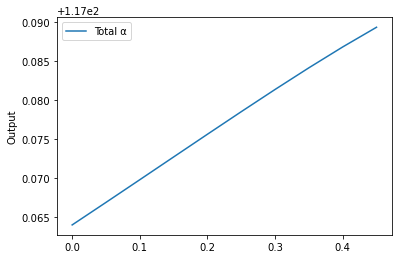

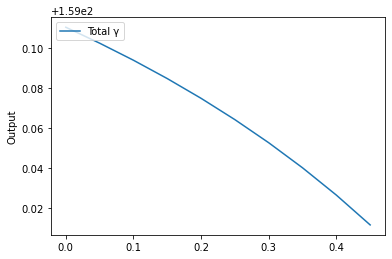

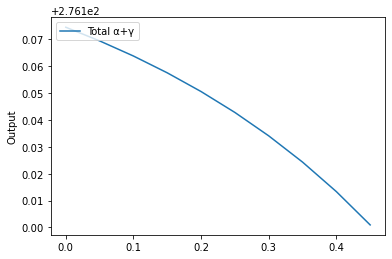

In [16]:
τ_k = np.arange(0,.5,.05)
α_k = np.zeros(τ_k.size)
γ_k = np.zeros(τ_k.size)
Φ_k = np.zeros(τ_k.size)
for k in range(τ_k.size ):
    # Φτ_x_y = α_x_y + (1-τ_k[k])* γ_x_y
    lintax_mkt = TU_model(α_x_y + (1-τ_k[k])* γ_x_y, T = 1-τ_k[k] / 2)
    lintax_mkt.solveChooSiowIPFP()
    α_k[k] = np.sum(lintax_mkt.eq_μ_x_y * (α_x_y - np.log(lintax_mkt.eq_μ_x_y)) )
    γ_k[k] = np.sum(lintax_mkt.eq_μ_x_y * (γ_x_y - np.log(lintax_mkt.eq_μ_x_y)) )
    Φ_k[k] = np.sum(lintax_mkt.eq_μ_x_y * (α_x_y+γ_x_y - 2 * np.log(lintax_mkt.eq_μ_x_y)))

import matplotlib.pyplot as plt

plt.plot(τ_k,α_k)
plt.legend(['Total α'], loc='upper left')
plt.ylabel('Output')
plt.show()

plt.plot(τ_k,γ_k)
plt.legend(['Total γ'], loc='upper left')
plt.ylabel('Output')
plt.show()

plt.plot(τ_k,Φ_k)
plt.legend(['Total α+γ'], loc='upper left')
plt.ylabel('Output')
plt.show()